In [1]:
import rl
import yaml
from stable_baselines import PPO2
from stable_baselines.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import rl.helpers
import cv2
import math
import random
import statistics as sts
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import datetime as dt
from os.path import join
import pathlib
import numpy as np

environment = 'ConveyorEnv11'

config_path = 'rl/config/{}.yml'.format(environment)
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
env_obj = getattr(rl.environments, environment)
env = env_obj(config)

print('Model Parameters are: \n')
print('\t Queue length:\t\t\t{} \n \t Pipeline length: \t\t{}'.format(env.gtp_buffer_length, env.pipeline_length))
print('\t Amount GtP:\t\t\t{} \n \t Types of order carriers: \t{}'.format(env.amount_of_gtps, env.amount_of_outputs))
print('\t To process orders:\t\t{}/{} \n \t Termination condition: \t{}\n'.format(env.max_items_processed, env.amount_of_gtps*env.gtp_demand_size, env.termination_condition))
env.render_plt()

Model Parameters are: 

	 Queue length:			7 
 	 Pipeline length: 		10
	 Amount GtP:			2 
 	 Types of order carriers: 	2
	 To process orders:		150/200 
 	 Termination condition: 	3



<Figure size 640x480 with 1 Axes>

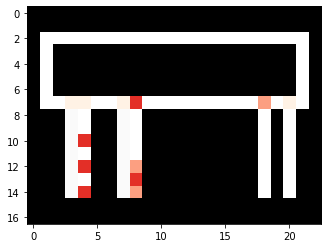

In [10]:
env.reset()
env.render_plt()

In [3]:
def plot_from_dict(data_dict, topic):
    """
    builds plot with the idle time and the recirculation factor
    """
    #plot in a plotly graph
    data = pd.DataFrame.from_dict(data_dict).T.reset_index()
    data['index'] = data['index'].str.replace('lane_l_','buffersize=')
    data['index'] = data['index'].str.replace('pipel_','')

    fig = make_subplots(rows=2, cols=1)
    fig.append_trace(go.Scatter(
        x=data['index'],
        y=data.idle_time,
        name='Idle time operators'
    ), row=1, col=1)

    fig.append_trace(go.Scatter(
        x=data['index'],
        y=data.cycle_count,
        name='Recirculation carriers'
    ), row=2, col=1, )

    fig.update_layout(
        height=600, 
        width=1000, 
        title_text="Influence of {} on idle time and re-circulation".format(topic),
                     )
    fig.show()
    
def plot_idletime(data, ylabel):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(15, 5))
    data['index'] = data['index'].str.replace('lane_l_','buffersize=')
    plt.plot(data['index'], data.idle_time, color ='red')
    plt.xlabel('Size of the GtP buffer')
    plt.ylabel(ylabel)
    plt.legend(['heuristic'])
    fig.show()
    
def plot_cycle_count(data, ylabel):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(15, 5))
    data['index'] = data['index'].str.replace('lane_l_','buffersize=')
    plt.plot(data['index'], data.cycle_count, color ='red')
    plt.xlabel('Size of the GtP buffer')
    plt.ylabel(ylabel)
    plt.legend(['heuristic'])
    fig.show()

In [4]:
# Run 100 episodes to test this initial setup
no_episodes = 100

results = {}
results['idle_time'] = 0
results['cycle_count'] = 0
results['steps'] = 0

for episode in range(no_episodes):
    print('episode: {} \t steps: \t {}'.format(episode, env.steps), end='\r')
    env.reset()
    while not env.terminate:
        env.step_on_process_time()
    results['idle_time'] += sum(env.idle_times_operator.values())
    results['cycle_count'] += env.cycle_count
    results['steps'] += env.steps
    
# print('Mean idle time of operators over {} episodes: \t {}'.format(no_episodes, sts.mean(idle_time)))
# print('Mean cycle_count of carriers over {} episodes: \t {}%'.format(no_episodes, sts.mean(cycle_count)))
# print('Average of {} steps per episode.'.format(sts.mean(steps)))

print('Mean idle time of operators over {} episodes: \t {}'.format(no_episodes, results['idle_time'] / no_episodes))
print('Mean cycle_count of carriers over {} episodes:\t {}%'.format(no_episodes, results['cycle_count'] / no_episodes))
print('Average of \t{} \t steps per episode.'.format(results['steps'] / no_episodes))
print('On average, over a planning horizon of  {} (hh:mm:ss) (day) the operators were {} seconds idle.'.format(str(dt.timedelta(seconds=results['steps'] / no_episodes)), results['idle_time'] / no_episodes))

Mean idle time of operators over 100 episodes: 	 0.25
Mean cycle_count of carriers over 100 episodes:	 0.63%
Average of 	764.33 	 steps per episode.
On average, over a planning horizon of  0:12:44.330000 (hh:mm:ss) (day) the operators were 0.25 seconds idle.


2

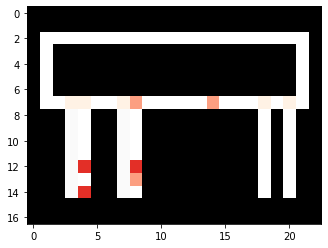

In [14]:
env.render_plt()

In [18]:
#run 1 episode with render to visually check the performance
env.reset()
while not env.terminate:
    env.step_on_process_time()
    env.render()

KeyboardInterrupt: 

In [58]:
for i in range(5):
    print('mean: ', log_dataframe[i].mean(), 'std: ', log_dataframe[i].std())

mean:  0.5150891960399827 std:  0.08493190238101442
mean:  0.4947151944138886 std:  0.09735144388753636
mean:  0.47190205174805105 std:  0.1152432493422128
mean:  0.4637237553206753 std:  0.10279728530240212
mean:  0.41800181739920605 std:  0.13036598352864023


# Calculate performance measures

In [5]:
configurations = [
    [1,2],
    [2,2],
    [2,3],
    [3,3],
    [4,3],
    [5,3],
]

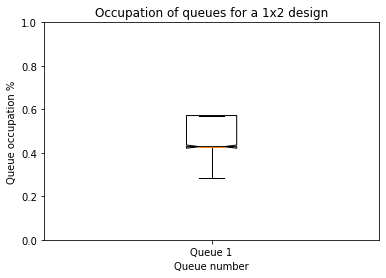

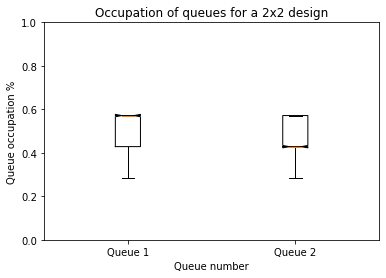

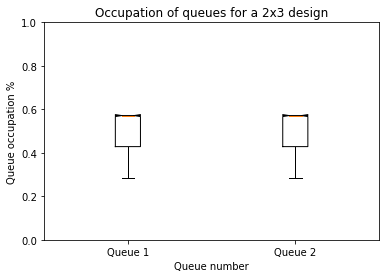

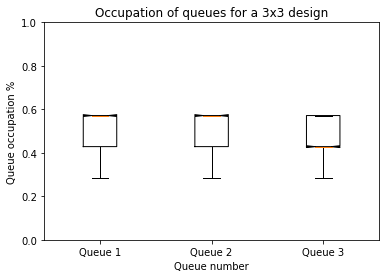

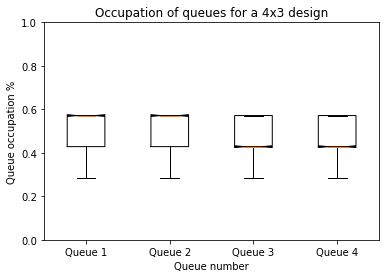

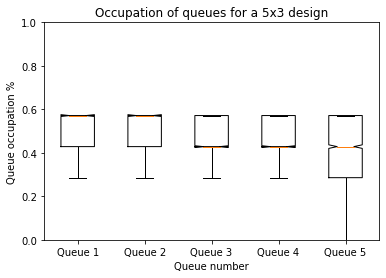

In [57]:
#Calculate boxplots for the  different designs

for configuration in configurations:
    no_gtp, output= configuration
    config['environment']['amount_of_gtps'] = no_gtp
    config['environment']['amount_of_outputs'] = output
    
    env = AbstractConveyor(config)
    
    #run 1 episode with render to visually check the performance
    log_data = []
    env.reset()
    while not env.terminate:
        env.do_heuristic_guided_step()
        #env.render()
        log_data.append(env.len_queues)
    log_dataframe = pd.DataFrame(np.array(log_data)).reset_index()
    log_dataframe.head()

    labels = ['Queue 1', 'Queue 2', 'Queue 3', 'Queue 4', 'Queue 5']
    plt.boxplot([log_dataframe[i] for i in range(env.amount_of_gtps)], notch=True, labels=[label for label in labels][:env.amount_of_gtps], showfliers=False)
    plt.ylim(0,1)
    plt.ylabel('Queue occupation %')
    plt.xlabel('Queue number')
    plt.title('Occupation of queues for a {}x{} design'.format(no_gtp, output))
    plt.show()

In [15]:
# calculate mean performance for idle time and recirculation of carriers

all_results = {}

for configuration in configurations:
    
    no_gtp, output= configuration
    all_results['{}x{}'.format(no_gtp, output)] = {}
    all_results['{}x{}'.format(no_gtp, output)]['idle_time'] = 0
    all_results['{}x{}'.format(no_gtp, output)]['cycle_count'] = 0
    all_results['{}x{}'.format(no_gtp, output)]['steps'] = 0
    
    config['environment']['amount_of_gtps'] = no_gtp
    config['environment']['amount_of_outputs'] = output
    
    env = ConveyorEnv1(config)

    no_episodes = 100
    print('Start run for {}x{} design'.format(no_gtp, output))
    for episode in range(no_episodes):
        print('episode: {} \t steps: \t {}'.format(episode, env.steps), end='\r')
        env.reset()
        while not env.terminate:
            env.step_on_process_time()
        all_results['{}x{}'.format(no_gtp, output)]['idle_time'] += sum(env.idle_times_operator.values())
        all_results['{}x{}'.format(no_gtp, output)]['cycle_count'] += env.cycle_count
        all_results['{}x{}'.format(no_gtp, output)]['steps'] += env.steps
        
    all_results['{}x{}'.format(no_gtp, output)]['idle_time'] = all_results['{}x{}'.format(no_gtp, output)]['idle_time'] / no_episodes
    all_results['{}x{}'.format(no_gtp, output)]['cycle_count'] = all_results['{}x{}'.format(no_gtp, output)]['cycle_count'] / no_episodes
    all_results['{}x{}'.format(no_gtp, output)]['steps'] = all_results['{}x{}'.format(no_gtp, output)]['steps'] / no_episodes
resultcsv = pd.DataFrame.from_dict(all_results).T
resultcsv

Start run for 1x2 design
Start run for 2x2 designR: 790.000
Start run for 2x3 design: 780.000
Start run for 3x3 designR: 790.000
Start run for 4x3 design: 740.0000
Start run for 5x3 design: 750.000


,idle_time,cycle_count,steps
1x2,0.00,0.45,1527.42
2x2,0.35,0.29,760.99
2x3,0.00,0.00,1328.34
3x3,6.09,0.89,898.55
4x3,2.56,0.78,675.82
5x3,2.43,0.59,546.07


In [16]:
resultcsv.to_csv('evaluation_results/result_heuristic_stochastic.csv')

# Check for effect on changing the GTP buffer length

In [15]:
#we decrease the bufferlane length for each run
max_length = 10
no_episodes = 50

diff_lane_r = {}

config_path = 'rl/config/ConveyorEnv11.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

for lane_l in range(1,max_length+1)[::-1]:                #decending
    
    config['environment']['gtp_buffer_length'] = lane_l
    env = env_obj(config)
    results = {}
    results['idle_time'] = 0
    results['cycle_count'] = 0
    results['steps'] = 0

    for episode in range(no_episodes):
        print('lane length: {} \t episode: {} \t steps: \t {}'.format(lane_l, episode, env.steps), end='\r')
        env.reset()
        while not env.terminate:
            env.step_on_process_time()
        results['idle_time'] += sum(env.idle_times_operator.values())
        results['cycle_count'] += env.cycle_count
        results['steps'] += env.steps
    
    diff_lane_r['lane_l_{}'.format(lane_l)] = {
        'idle_time' : results['idle_time']/no_episodes,
        'cycle_count' : results['cycle_count']/no_episodes,
        'steps' : results['steps']/no_episodes
    }

data = pd.DataFrame.from_dict(diff_lane_r).T.reset_index()
data.to_csv('evaluation_results/{}x{}_var_bufsize_stochastic.csv'.format(env.amount_of_gtps, env.amount_of_outputs))
data

,index,idle_time,cycle_count,steps
0,lane_l_10,0.00,0.12,1408.10
1,lane_l_9,0.06,0.24,1441.16
2,lane_l_8,0.00,0.00,1423.88
3,lane_l_7,0.00,0.02,1424.32
4,lane_l_6,0.00,0.16,1410.04
5,lane_l_5,1.22,1.86,1433.12
6,lane_l_4,29.12,31.72,1443.44
7,lane_l_3,118.76,120.62,1492.12
8,lane_l_2,382.98,287.54,1635.74
9,lane_l_1,335.62,261.96,1622.38


In [5]:
df2.idle_time

9      0.00
8      2.27
7      0.00
6      0.64
5      1.13
4      1.48
3      1.70
2    194.65
1    242.34
0    358.24
Name: idle_time, dtype: float64

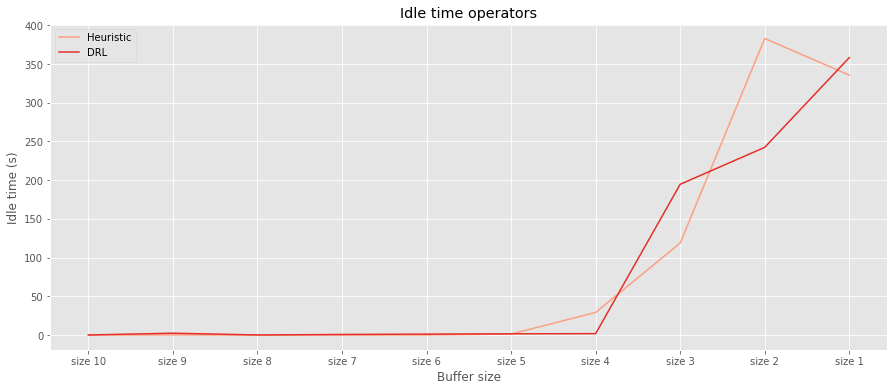

In [6]:
import seaborn as sns
plt.style.use('ggplot')
df1 = pd.read_csv('evaluation_results/2x2_var_bufsize_stochastic.csv', index_col=0, delimiter=';')
df2 = pd.read_csv('evaluation_results/results_DRL_buffer.csv')
labels = ['size {}'.format(i) for i in range(1,11)[::-1] ]
intdata = (np.array(sns.color_palette("Reds", 2)) * 255).astype(int)
hexen = ['#%02x%02x%02x' % tuple(code) for code in intdata]
fig = plt.figure(figsize=(15, 6))
plt.plot(labels, df1.idle_time, color =hexen[0], label='Heuristic')
plt.plot(labels, df2.idle_time[::-1], color =hexen[1], label='DRL')
plt.title('Idle time operators')
plt.legend()
plt.ylabel('Idle time (s)')
plt.xlabel('Buffer size')
plt.xticks = labels
plt.show()

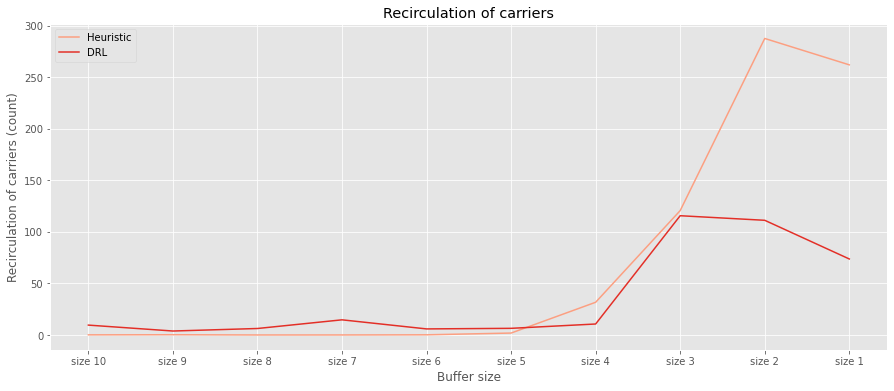

In [8]:
fig = plt.figure(figsize=(15, 6))
plt.plot(labels, df1.cycle_count, color =hexen[0], label='Heuristic')
plt.plot(labels, df2.cycle_count[::-1], color =hexen[1], label='DRL')
plt.title('Recirculation of carriers')
plt.legend()
plt.ylabel('Recirculation of carriers (count)')
plt.xlabel('Buffer size')
plt.xticks = labels
plt.show()

# Check for the influence of pipeline length

In [22]:
#we decrease the bufferlane length for each run
max_length = 50
stepsize = 5
no_episodes = 100

config_path = 'rl/config/ConveyorEnv11.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
    
diff_pipe_r = {}

for pipe_l in range(5,max_length+stepsize, stepsize):                #ascending
    
    config['environment']['pipeline_length'] = pipe_l
    env = env_obj(config)
    results = {}
    results['idle_time'] = 0
    results['cycle_count'] = 0
    results['steps'] = 0

    for episode in range(no_episodes):
        print('pipeline length: {} \t episode: {} \t steps: \t {}'.format(pipe_l, episode, env.steps), end='\r')
        env.reset()
        while not env.terminate:
            env.step_on_process_time()
        results['idle_time'] += sum(env.idle_times_operator.values())
        results['cycle_count'] += env.cycle_count
        results['steps'] += env.steps
    
    diff_pipe_r['pipel_{}'.format(pipe_l)] = {
        'idle_time' : results['idle_time']/no_episodes,
        'cycle_count' : results['cycle_count']/no_episodes,
        'steps' : results['steps']/no_episodes
    }
data = pd.DataFrame.from_dict(diff_pipe_r).T.reset_index()
data.to_csv('evaluation_results/{}x{}_diff_pipe_sto.csv'.format(env.amount_of_gtps, env.amount_of_outputs))

In [23]:
data

,index,idle_time,cycle_count,steps
0,pipel_5,0.00,0.42,1448.38
1,pipel_10,0.30,0.34,1437.72
2,pipel_15,5.16,5.42,1435.86
3,pipel_20,18.00,10.64,1439.58
4,pipel_25,60.78,23.64,1471.52
5,pipel_30,142.00,45.18,1514.24
6,pipel_35,227.10,62.00,1534.24
7,pipel_40,306.94,70.84,1586.52
8,pipel_45,497.22,102.74,1656.66
9,pipel_50,588.86,105.94,1733.12


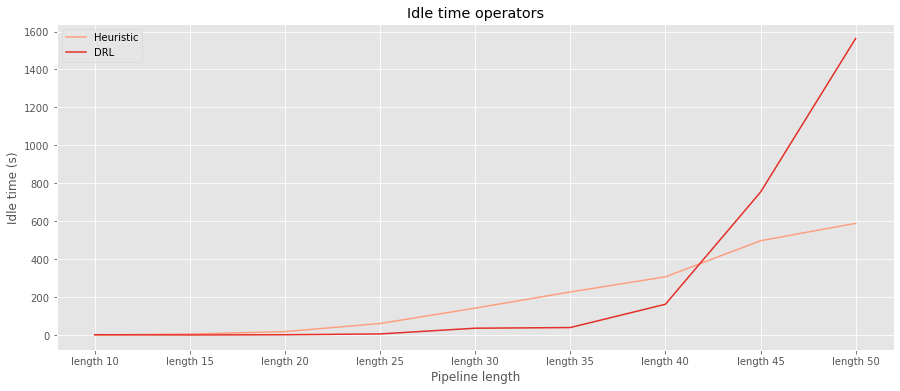

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
df1 = pd.read_csv('evaluation_results/2x2_diff_pipe_sto.csv', delimiter=';', index_col=0)
df2 = pd.read_csv('evaluation_results/results_DRL_pipe.csv', delimiter=';')
labels = ['length {}'.format(i) for i in range(10,55,5)]#[::-1] ]
intdata = (np.array(sns.color_palette("Reds", 2)) * 255).astype(int)
hexen = ['#%02x%02x%02x' % tuple(code) for code in intdata]
fig = plt.figure(figsize=(15, 6))
plt.plot(labels, df1.idle_time, color =hexen[0], label='Heuristic')
plt.plot(labels, df2.idle_time, color =hexen[1], label='DRL')
plt.title('Idle time operators')
plt.legend()
plt.ylabel('Idle time (s)')
plt.xlabel('Pipeline length')
plt.xticks = labels
plt.show()

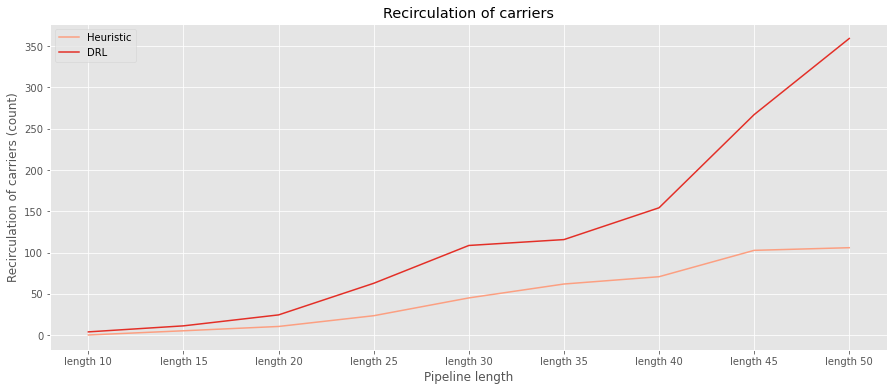

In [5]:
fig = plt.figure(figsize=(15, 6))
plt.plot(labels, df1.cycle_count, color =hexen[0], label='Heuristic')
plt.plot(labels, df2.cycle_count, color =hexen[1], label='DRL')
plt.title('Recirculation of carriers')
plt.legend()
plt.ylabel('Recirculation of carriers (count)')
plt.xlabel('Pipeline length')
plt.xticks = labels
plt.show()

# For the effect on speed increase by operators

In [75]:
#we decrease the bufferlane length for each run
max_improvement = 40 #procent
stepsize = 2
no_episodes = 50

config_path = 'rl/config/AbstractConveyor.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
    
diff_speed_r = {}

for speed in range(0,max_improvement+stepsize, stepsize):
    speed_imp = speed/100
    
    config['environment']['speed_improvement'] = speed_imp
    env = AbstractConveyor(config)
    results = {}
    results['idle_time'] = 0
    results['cycle_count'] = 0
    results['steps'] = 0

    for episode in range(no_episodes):
        print('Operator speed improvement: {} \t episode: {} \t steps: \t {}'.format(speed_imp, episode, env.steps), end='\r')
        env.reset()
        while not env.terminate:
            self.do_heuristic_guided_step()
        results['idle_time'] += sum(env.idle_times_operator.values())
        results['cycle_count'] += env.cycle_count
        results['steps'] += env.steps
    
    diff_speed_r['impr_{}'.format(speed_imp)] = {
        'idle_time' : results['idle_time']/no_episodes,
        'cycle_count' : results['cycle_count']/no_episodes,
        'steps' : results['steps']/no_episodes
    }
    

NameError: name 'do_heuristic_guided_step' is not defined

In [121]:
plot_from_dict(diff_speed_r, 'operator speed improvement')

# influence of the amount of GtP on the errors

In [123]:
#we decrease the bufferlane length for each run
max_improvement = 15 
stepsize = 2
no_episodes = 50

config_path = 'rl/config/AbstractConveyor.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
    
diff_gtp_no_r = {}

for gtp_no in range(3,max_improvement+stepsize, stepsize):
    
    config['environment']['amount_of_gtps'] = gtp_no
    env = AbstractConveyor(config)
    results = {}
    results['idle_time'] = 0
    results['cycle_count'] = 0
    results['steps'] = 0

    for episode in range(no_episodes):
        print('Amount of gtp: {} \t episode: {} \t steps: \t {}'.format(gtp_no, episode, env.steps), end='\r')
        env.reset()
        while not env.terminate:
            do_heuristic_guided_step()
        results['idle_time'] += sum(env.idle_times_operator.values())
        results['cycle_count'] += env.cycle_count
        results['steps'] += env.steps
    
    diff_gtp_no_r['gtp_no_{}'.format(gtp_no)] = {
        'idle_time' : results['idle_time']/no_episodes,
        'cycle_count' : results['cycle_count']/no_episodes,
        'steps' : results['steps']/no_episodes
    }
    

In [124]:
plot_from_dict(diff_gtp_no_r, 'amount of gtp')